In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)


In [36]:
import pandas as pd

processed_df = pd.read_csv('data_processed.csv')
processed_df.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,NaN
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,NaN
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,NaN
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,NaN
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,NaN


In [37]:
processed_df['TX_INTERVAL'].fillna(0, inplace=True)

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_14428/3515551195.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['TX_INTERVAL'].fillna(0, inplace=True)


In [38]:
processed_df_drop = processed_df.dropna()

In [39]:
processed_df_drop.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,0.0
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,0.0
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,0.0
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,0.0
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,0.0


In [40]:
from sklearn.preprocessing import StandardScaler

df_copy = processed_df_drop.copy()

scaler = StandardScaler()
df_copy['TX_AMT'] = scaler.fit_transform(df_copy[['TX_AMT']])

df_copy['TX_TIME'] = pd.to_datetime(df_copy['TX_DTTM']).dt.hour + pd.to_datetime(df_copy['TX_DTTM']).dt.minute / 60

In [41]:
cleaned_df = df_copy[['MBR_NO', 'TX_TIME','TX_AMT', 'TX_TYPE', 'BIS_NM', 'REGULAR_YN', 'TX_INTERVAL']].copy()

cleaned_df.head()

,MBR_NO,TX_TIME,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,23.500000,-8.849636,2,0,0,0.0
1,1303,19.250000,-8.821235,2,0,0,0.0
2,1349,16.300000,-6.208327,2,0,0,0.0
3,1349,0.500000,-4.742732,2,0,0,0.0
4,1303,5.333333,-0.237293,0,0,0,0.0


In [42]:
print(cleaned_df['REGULAR_YN'].value_counts())


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64


### 불균형 확인

In [43]:
cleaned_df['REGULAR_YN'].value_counts()


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64

In [44]:
import numpy as np

features = cleaned_df.values
labels = np.array(cleaned_df.pop('REGULAR_YN'))

print(features.shape)
print(labels.shape)

(2503033, 7)
(2503033,)


In [45]:
from sklearn.model_selection import train_test_split


# 훈련/임시 테스트 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 임시 테스트 데이터를 테스트/검증으로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")



훈련 데이터 크기: (1251516, 7), 검증 데이터 크기: (625758, 7), 테스트 데이터 크기: (625759, 7)


In [46]:
from collections import Counter

print(Counter(labels))
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))




Counter({np.int64(0): 2500973, np.int64(1): 2060})
Counter({np.int64(0): 1250486, np.int64(1): 1030})
Counter({np.int64(0): 625243, np.int64(1): 515})
Counter({np.int64(0): 625244, np.int64(1): 515})


In [47]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### 정상거래로만 오토인코더 학습

In [48]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]
print(X_train_normal.shape, X_train_fraud.shape)

(1250486, 7) (1030, 7)


In [49]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]
print(X_test_normal.shape, X_test_fraud.shape)


(625244, 7) (515, 7)


### DNN 모델 정의 - 정상 데이터만 사용

In [50]:
input_layer = Input(shape=(7,))
encoded_normal = Dense(4, activation='relu')(input_layer)
decoded_normal = Dense(7, activation='sigmoid')(encoded_normal)

autoencoder_normal = Model(input_layer, decoded_normal)
autoencoder_normal.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67 (268.00 B)

 Trainable params: 67 (268.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
autoencoder_normal.compile(optimizer='adam', loss='mse')

### 정상 데이터로만 train

In [52]:
history = autoencoder_normal.fit(X_train_normal, X_train_normal, epochs=30, batch_size=128, validation_data=(X_test_normal, X_test_normal))

Epoch 1/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 329us/step - loss: 0.7090 - val_loss: 0.6020
Epoch 2/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 4s 399us/step - loss: 0.6013 - val_loss: 0.5899
Epoch 3/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 343us/step - loss: 0.5898 - val_loss: 0.5876
Epoch 4/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 317us/step - loss: 0.5884 - val_loss: 0.5873
Epoch 5/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 317us/step - loss: 0.5881 - val_loss: 0.5871
Epoch 6/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 320us/step - loss: 0.5879 - val_loss: 0.5868
Epoch 7/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 328us/step - loss: 0.5877 - val_loss: 0.5864
Epoch 8/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 321us/step - loss: 0.5873 - val_loss: 0.5832
Epoch 9/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 316us/step - loss: 0.5838 - val_loss: 0.5823
Epoch 10/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 315us/step - loss: 0.5831 - val_loss: 0.5821
Epoch 11/30
9770/9770 ━━━━━━━━━━━━━━━━━━━━ 3s 321us/step - loss: 0.5830 - val_loss: 0.5821
Epoch 12

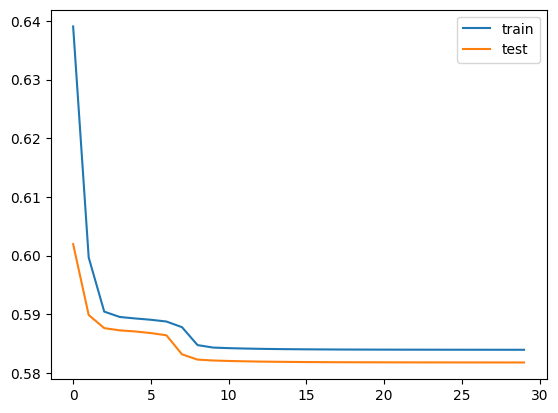

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


### Reconstruction Error 시각화

비교를 위해 정상/비정상 개수를 맞춤

In [54]:
indices = np.random.choice(len(X_train_normal), 1030, replace=False)
Nom_data = X_train_normal[indices]
Nom_data.shape

(1030, 7)

### 정상data와 fraud data의 autoencoder 재구성 값 비교

In [55]:
Nom_pred = autoencoder_normal.predict(Nom_data, verbose=0)
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1)
Nom_pred_mse_df = pd.DataFrame({'Normal_MSE': Nom_pred_mse})
Nom_pred_mse_df

,Normal_MSE
0,0.462521
1,0.035841
2,0.038991
3,0.837866
4,0.158647
...,...
1025,0.055123
1026,0.593318
1027,0.050468
1028,0.043893


In [56]:
Nom_pred_mse_df.describe()

,Normal_MSE
count,1030.000000
mean,0.593523
std,2.279559
min,0.009990
25%,0.051607
50%,0.144606
75%,0.494942
max,45.449130


### Fraud data의 autoencoder 재구성

In [57]:
ANom_pred = autoencoder_normal.predict(X_train_fraud, verbose=0)
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1)
ANom_pred_mse_df = pd.DataFrame({'ANormal_MSE': ANom_pred_mse})
ANom_pred_mse_df

ANom_pred_mse_df.describe()

,ANormal_MSE
count,1030.000000
mean,177.522931
std,3.201762
min,172.950057
25%,176.894688
50%,177.190818
75%,177.595977
max,223.775009


### 막대그래프 시각화

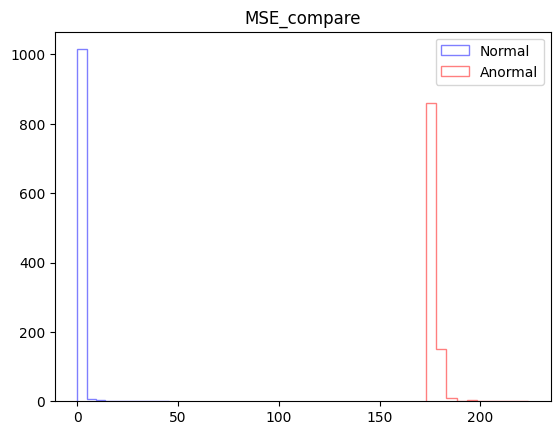

In [58]:
plt.title('MSE_compare')
plt.hist(Nom_pred_mse_df['Normal_MSE'], bins=10, alpha=0.5, label='Normal', color='blue', histtype='step')
plt.hist(ANom_pred_mse_df['ANormal_MSE'], bins=10, alpha=0.5, label='Anormal', color='red', histtype='step')
plt.legend()
plt.show()


### Boxplot 시각화

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_14428/4197399980.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([Nom_pred_mse_df['Normal_MSE'], ANom_pred_mse_df['ANormal_MSE']], labels=['Normal', 'Anormal'])


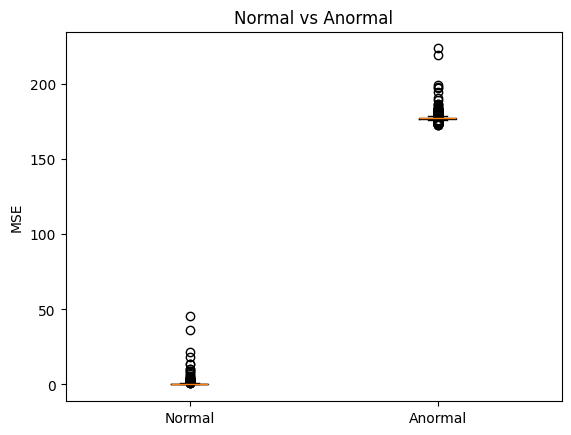

In [59]:
plt.boxplot([Nom_pred_mse_df['Normal_MSE'], ANom_pred_mse_df['ANormal_MSE']], labels=['Normal', 'Anormal'])
plt.title('Normal vs Anormal')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Anormal'])
plt.ylabel('MSE')
plt.show()


### Reconstruction Error Threshold 설정

In [60]:
predictions = autoencoder_normal.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})
error_df.head()


39110/39110 ━━━━━━━━━━━━━━━━━━━━ 8s 206us/step


,reconstruction_error,true_class
0,0.035299,0
1,0.108435,0
2,0.088517,0
3,0.317756,0
4,0.075605,0


In [61]:
desc = error_df.groupby('true_class').describe()
desc


reconstruction_error                                                \
                          count        mean       std         min         25%   
true_class                                                                      
0                     1250486.0    0.583951  2.312481    0.008874    0.055741   
1                        1030.0  177.522931  3.201762  172.950057  176.894688   

                                                
                   50%         75%         max  
true_class                                      
0             0.167045    0.490341   75.018289  
1           177.190818  177.595977  223.775009

### Threshold 설정 : mean + 3*std 로 설정

In [62]:
mean = desc['reconstruction_error']['mean'][0]
std = desc['reconstruction_error']['std'][0]
threshold = {"2sigma": mean + 2*std, "2.5sigma": mean + 2.5*std, "3sigma": mean + 3*std}
threshold, mean, std


({'2sigma': np.float64(5.208912917167439),
  '2.5sigma': np.float64(6.365153494796574),
  '3sigma': np.float64(7.521394072425708)},
 np.float64(0.5839506066508989),
 np.float64(2.31248115525827))

In [63]:
test_predictions = autoencoder_normal.predict(X_test)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
mse.shape

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 206us/step


(625759,)

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 206us/step
f1_score 0.14
Precision 0.07
Recall 1.00


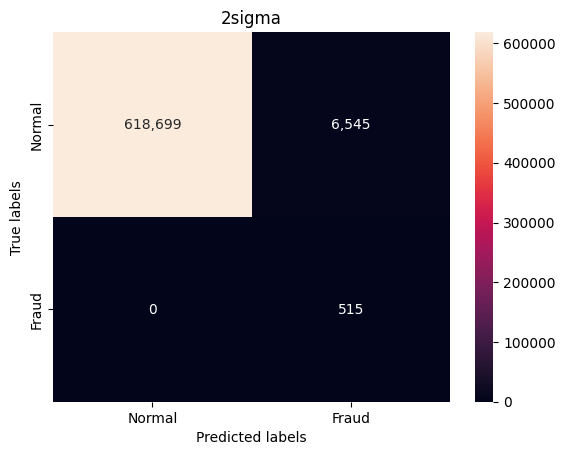

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 209us/step
f1_score 0.16
Precision 0.09
Recall 1.00


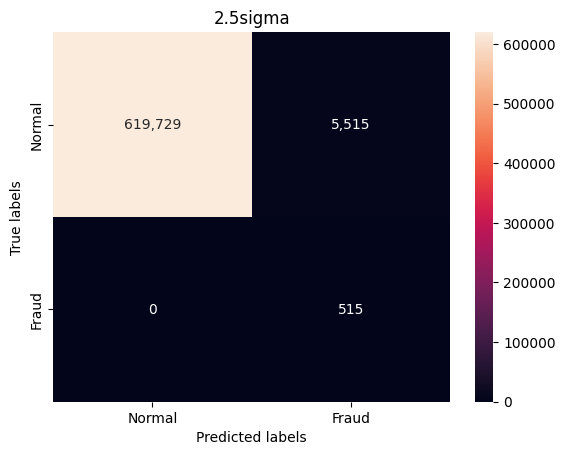

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 206us/step
f1_score 0.18
Precision 0.10
Recall 1.00


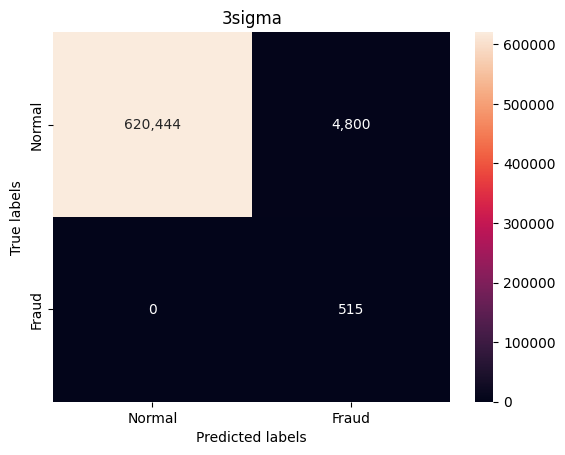

In [64]:
from sklearn.metrics import f1_score
# 임계값(thresholds)을 값에 따라 오름차순으로 정렬합니다.
# sorted() 함수와 lambda 함수를 사용하여 임계값을 기준으로 정렬합니다.
ths = sorted(threshold.items(), key=lambda kv: kv[1])

# 각 임계값에 대해 반복합니다.
for k, threshold in ths:
    # 오토인코더 모델을 사용하여 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = autoencoder_normal.predict(X_test)

    # 원본 데이터(X_test)와 예측된 데이터(test_predictions) 간의 MSE(Mean Squared Error)를 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # MSE 값이 임계값 이상이면 1, 그렇지 않으면 0으로 설정하여 예측된 레이블(y_pred)을 생성합니다.
    y_pred = [(lambda er: 1 if er >= threshold else 0)(er) for er in mse]
    
    print("f1_score {:.2f}".format(f1_score(y_test, y_pred)))
    # 정밀도(Precision)를 계산하여 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블을 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치를 설정합니다.
    ax.set_title(k)       # 그래프의 제목을 임계값 키(k)로 설정합니다.
    plt.show()

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve와 AUC
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = roc_auc_score(y_test, mse)

print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 1.0000


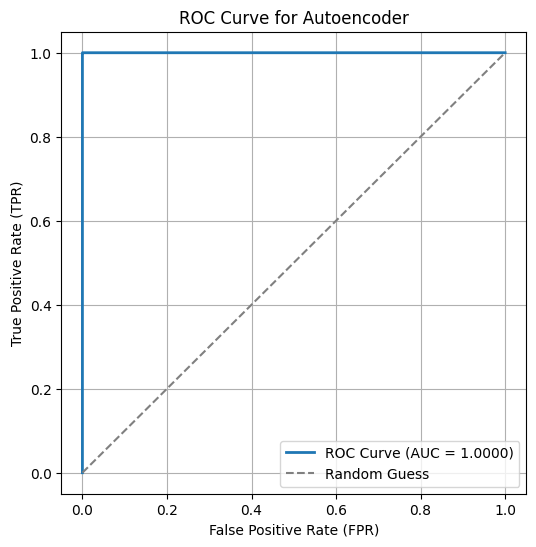

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title("ROC Curve for Autoencoder")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [67]:
# 임계값(thresholds)을 값에 따라 오름차순으로 정렬합니다.
# sorted() 함수와 lambda 함수를 사용하여 임계값을 기준으로 정렬합니다.
ths = sorted(threshold.items(), key=lambda kv: kv[1])

# 각 임계값에 대해 반복합니다.
for k, threshold in ths:
    # 오토인코더 모델을 사용하여 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = autoencoder_normal.predict(X_test)

    # 원본 데이터(X_test)와 예측된 데이터(test_predictions) 간의 MSE(Mean Squared Error)를 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # MSE 값이 임계값 이상이면 1, 그렇지 않으면 0으로 설정하여 예측된 레이블(y_pred)을 생성합니다.
    y_pred = [(lambda er: 1 if er >= threshold else 0)(er) for er in mse]

    # 정밀도(Precision)를 계산하여 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블을 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치를 설정합니다.
    ax.set_title(k)       # 그래프의 제목을 임계값 키(k)로 설정합니다.
    plt.show()

AttributeError: 'numpy.float64' object has no attribute 'items'

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 210us/step
Precision 0.15
Recall 1.00


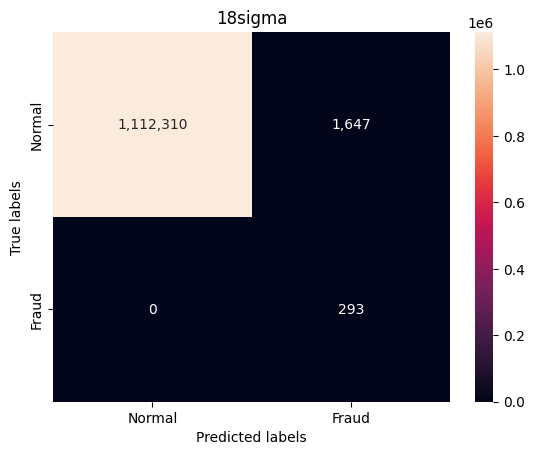

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 210us/step
Precision 0.15
Recall 1.00


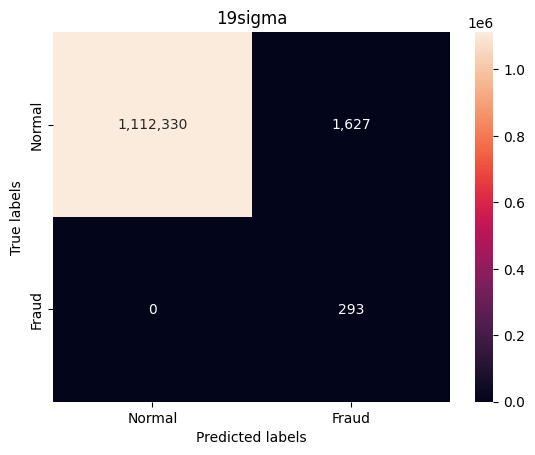

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 208us/step
Precision 0.15
Recall 1.00


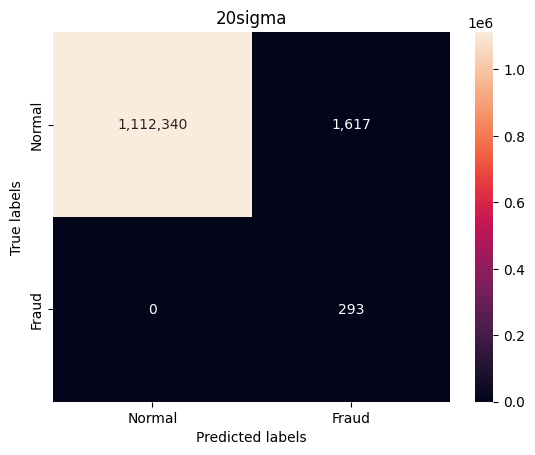

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 214us/step
Precision 0.15
Recall 1.00


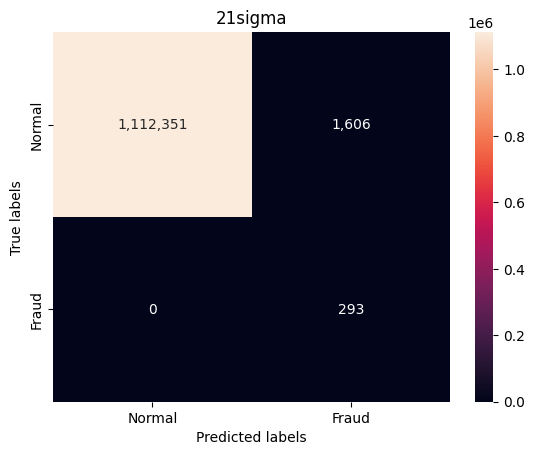

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 209us/step
Precision 0.44
Recall 1.00


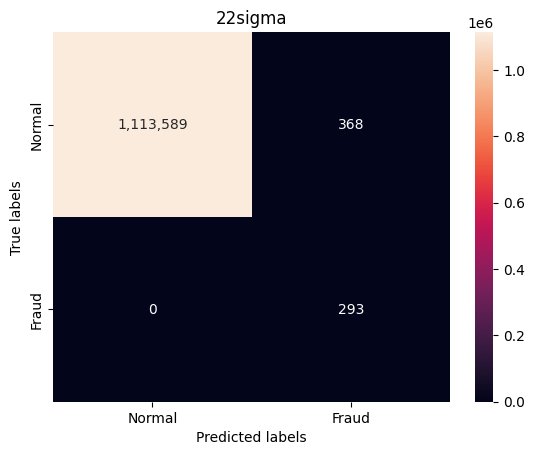

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 215us/step
Precision 0.83
Recall 1.00


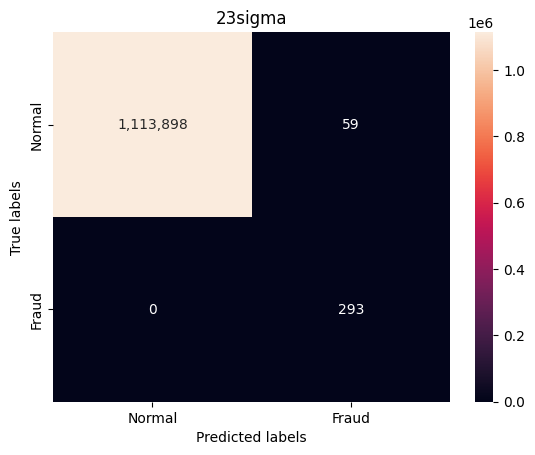

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 208us/step
Precision 0.92
Recall 1.00


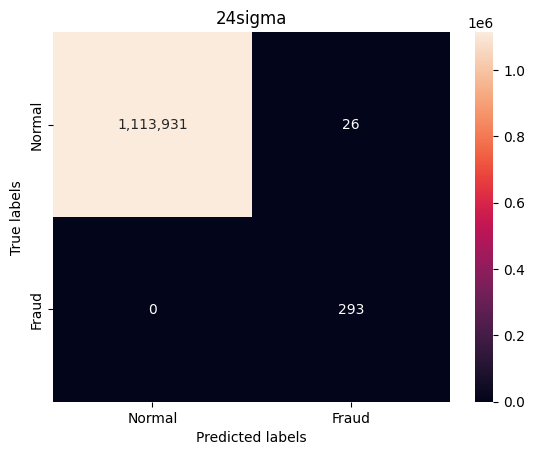

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 214us/step
Precision 0.94
Recall 1.00


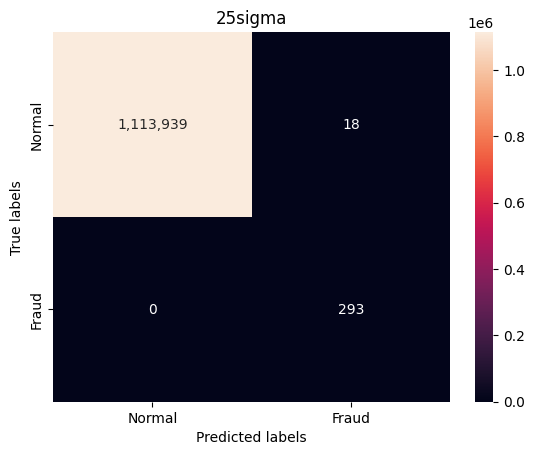

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 211us/step
Precision 0.96
Recall 1.00


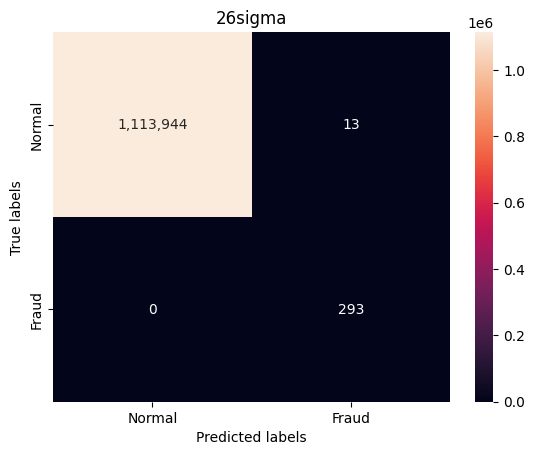

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 8s 222us/step
Precision 0.97
Recall 1.00


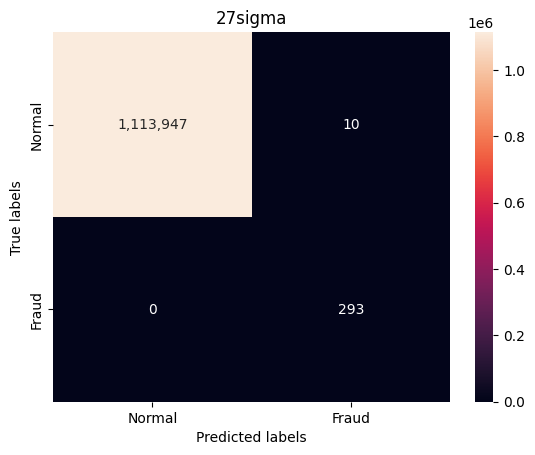

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 211us/step
Precision 0.97
Recall 1.00


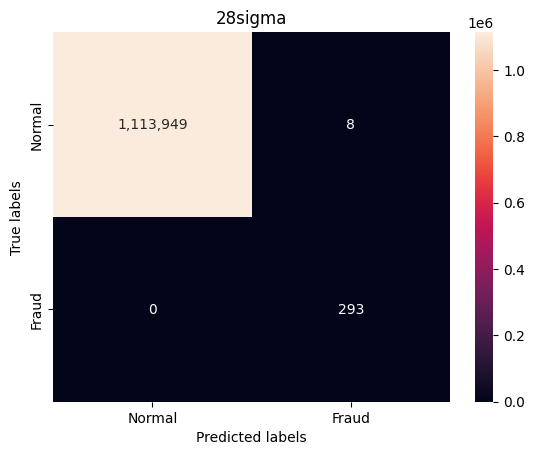

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 8s 224us/step
Precision 0.99
Recall 1.00


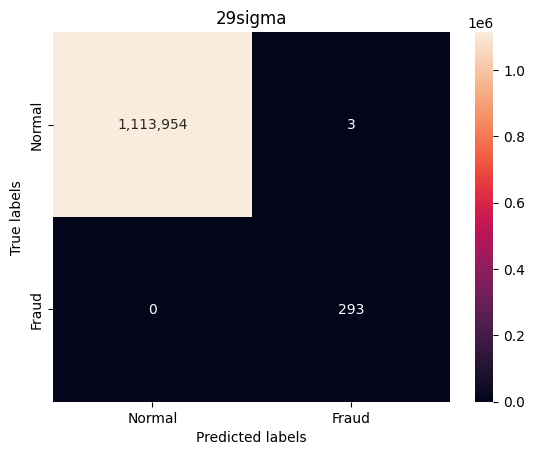

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 8s 218us/step
Precision 1.00
Recall 1.00


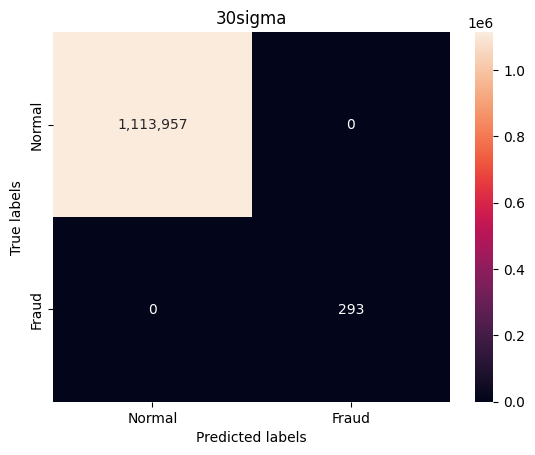

In [96]:
threshold = {"30sigma": mean + 30*std, "29sigma": mean + 29*std, "28sigma": mean + 28*std, "27sigma": mean + 27*std, "26sigma": mean + 26*std, "25sigma": mean + 25*std, "24sigma": mean + 24*std, "23sigma": mean + 23*std, "22sigma": mean + 22*std, "21sigma": mean + 21*std, "20sigma": mean + 20*std, "19sigma": mean + 19*std, "18sigma": mean + 18*std}


# 임계값(thresholds)을 값에 따라 오름차순으로 정렬합니다.
# sorted() 함수와 lambda 함수를 사용하여 임계값을 기준으로 정렬합니다.
ths = sorted(threshold.items(), key=lambda kv: kv[1])

# 각 임계값에 대해 반복합니다.
for k, threshold in ths:
    # 오토인코더 모델을 사용하여 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = autoencoder_normal.predict(X_test)

    # 원본 데이터(X_test)와 예측된 데이터(test_predictions) 간의 MSE(Mean Squared Error)를 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # MSE 값이 임계값 이상이면 1, 그렇지 않으면 0으로 설정하여 예측된 레이블(y_pred)을 생성합니다.
    y_pred = [(lambda er: 1 if er >= threshold else 0)(er) for er in mse]

    # 정밀도(Precision)를 계산하여 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블을 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치를 설정합니다.
    ax.set_title(k)       # 그래프의 제목을 임계값 키(k)로 설정합니다.
    plt.show()

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 8s 215us/step
Precision 0.00
Recall 1.00


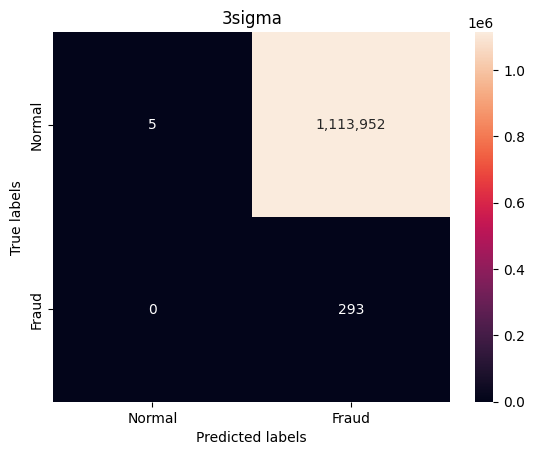

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 211us/step
Precision 0.00
Recall 1.00


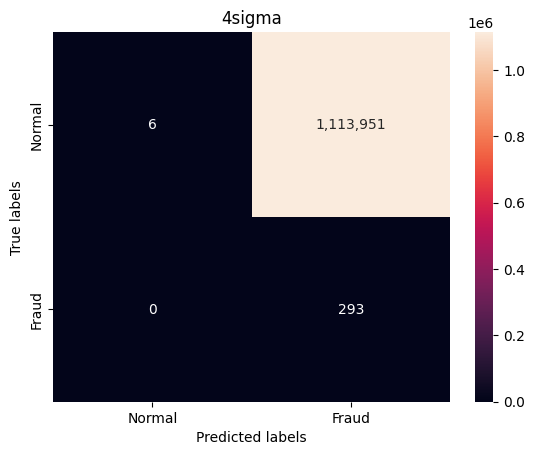

In [100]:
# 데이터 분리 및 전처리
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 오토인코더 모델 정의
autoencoder_normal = Sequential([
    Input(shape=(7,)),                    # 입력 레이어
    Dense(4, activation='relu'),          # 인코딩 레이어
    Dense(7, activation='sigmoid')       # 디코딩 레이어
])

# 임계값 설정
threshold = {"4sigma": mean + 4*std, "3sigma": mean + 3*std}
ths = sorted(threshold.items(), key=lambda kv: kv[1])
# 예측 및 평가
for k, threshold in ths:
    test_predictions = autoencoder_normal.predict(X_test)
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    y_pred = [(lambda er: 1 if er >= threshold else 0)(er) for er in mse]
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))
    
        # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블을 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치를 설정합니다.
    ax.set_title(k)       # 그래프의 제목을 임계값 키(k)로 설정합니다.
    plt.show()

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 8s 220us/step
Precision 0.00
Recall 1.00


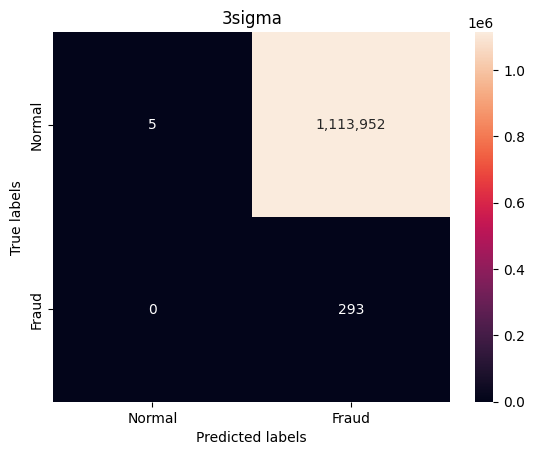

34821/34821 ━━━━━━━━━━━━━━━━━━━━ 7s 214us/step
Precision 0.00
Recall 1.00


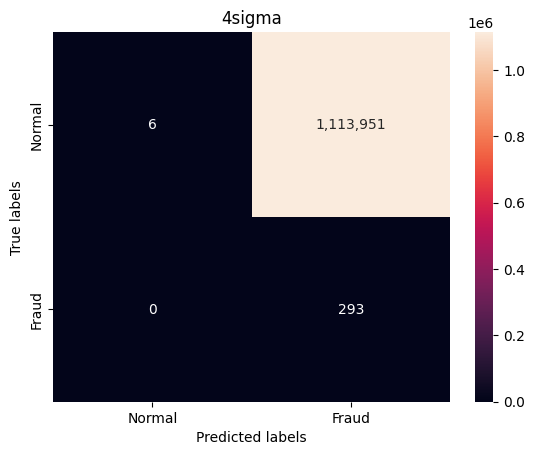

In [101]:
# 데이터 분리 및 전처리
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 오토인코더 모델 정의
autoencoder_normal = Sequential([
    Input(shape=(7,)),                    # 입력 레이어
    Dense(4, activation='relu'),          # 인코딩 레이어
    Dense(7, activation='sigmoid')       # 디코딩 레이어
])

# 임계값 설정
threshold = {"4sigma": mean + 4*std, "3sigma": mean + 3*std}
ths = sorted(threshold.items(), key=lambda kv: kv[1])


for k, threshold in ths:
    # 오토인코더 모델을 사용하여 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = autoencoder_normal.predict(X_test)

    # 원본 데이터(X_test)와 예측된 데이터(test_predictions) 간의 MSE(Mean Squared Error)를 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # MSE 값이 임계값 이상이면 1, 그렇지 않으면 0으로 설정하여 예측된 레이블(y_pred)을 생성합니다.
    y_pred = [(lambda er: 1 if er >= threshold else 0)(er) for er in mse]

    # 정밀도(Precision)를 계산하여 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블을 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치를 설정합니다.
    ax.set_title(k)       # 그래프의 제목을 임계값 키(k)로 설정합니다.
    plt.show()